# Beta series regression

1. [To Do](#to-do) <br>
2. [fMRIprep](#fmriprep) <br>
3. [Nibetaseries](#nibetaseries) <br>
4. Age Group Differences <br>
    1. [Mean FC during cue condition](#age-group-dif-mean-fc) <br>

HC node: x=-21, y=-9, z=-15) left anterior hc

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images
from bct import nbs
from scipy.io import savemat
from mne.viz import plot_connectivity_circle
import time

/usr/local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_dir = '/Volumes/psybrain/ADM/derivatives'
results_dir = '/Volumes/schnyer/Megan/adm_mem-fc/analysis/stats/'
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries'

tasks = ['MemMatch1', 'MemMatch2', 'MemMatch3']
trial_types = ['cue', 'match', 'mismatch']

atlas_file='/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz'
atlas_lut='/Volumes/psybrain/ADM/derivatives/nibs/power264_labels.tsv'

In [3]:
subjects = np.loadtxt(data_dir + '/nibs/subjects.txt', dtype=str)
subjects

array(['30004', '30008', '30009', '30015', '30019', '30020', '30023',
       '30040', '30057', '30064', '30066', '30069', '30074', '30085',
       '30088', '30090', '30091', '30095', '30096', '30105', '30116',
       '30118', '30119', '30128', '30181', '30217', '30227', '30236',
       '30242', '30255', '30274', '30283', '30295', '30330', '30346',
       '30376', '30395', '30400', '30403', '30412', '30426', '30432',
       '30466', '30469', '30476', '30478', '30568', '30570', '30581',
       '30584', '30588', '40160', '40170', '40175', '40288', '40351',
       '40490', '40512', '40519', '40520', '40524', '40547', '40564',
       '40615', '40619', '40624', '40638', '40649', '40650', '40656',
       '40658', '40664', '40665', '40668', '40672', '40685', '40694',
       '40720', '40738', '40743', '40750', '40773', '40778', '40796',
       '40803', '40855', '40861', '40930', '40961', '40968'], dtype='<U5')

In [4]:
atlas = pd.read_csv(atlas_lut, sep='\t').set_index('index')
atlas_all = atlas.append({'regions': 'L Anterior Hippocampus'}, ignore_index=True)
atlas_all = atlas_all.append({'regions': 'R Anterior Hippocampus'}, ignore_index=True)
atlas_all.regions.unique()

array(['Uncertain', 'Sensory/somatomotor Hand',
       'Sensory/somatomotor Mouth', 'Cingulo-opercular Task Control',
       'Auditory', 'Default mode', 'Memory retrieval?',
       'Ventral attention', 'Visual', 'Fronto-parietal Task Control',
       'Salience', 'Subcortical', 'Cerebellar', 'Dorsal attention',
       'L Anterior Hippocampus', 'R Anterior Hippocampus'], dtype=object)

In [5]:
dmn = atlas.loc[atlas['regions'].str.contains('Default|Hippocampus')].index.tolist()
fpn = atlas.loc[atlas['regions'].str.contains('Fronto-parietal')].index.tolist()
fpn_hc = atlas.loc[atlas['regions'].str.contains('Fronto-parietal|Hippocampus')].index.tolist()
dmn_fpn = np.concatenate((dmn, fpn))

In [6]:
from nilearn import datasets

power = datasets.fetch_coords_power_2011()

hc_coords = np.vstack([[-21,-9,-15], [21,-9,-15]])
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T
all_coords = np.vstack([coords, hc_coords])
coords

array([[-25, -98, -12],
       [ 27, -97, -13],
       [ 24,  32, -18],
       [-56, -45, -24],
       [  8,  41, -24],
       [-21, -22, -20],
       [ 17, -28, -17],
       [-37, -29, -26],
       [ 65, -24, -19],
       [ 52, -34, -27],
       [ 55, -31, -17],
       [ 34,  38, -12],
       [ -7, -52,  61],
       [-14, -18,  40],
       [  0, -15,  47],
       [ 10,  -2,  45],
       [ -7, -21,  65],
       [ -7, -33,  72],
       [ 13, -33,  75],
       [-54, -23,  43],
       [ 29, -17,  71],
       [ 10, -46,  73],
       [-23, -30,  72],
       [-40, -19,  54],
       [ 29, -39,  59],
       [ 50, -20,  42],
       [-38, -27,  69],
       [ 20, -29,  60],
       [ 44,  -8,  57],
       [-29, -43,  61],
       [ 10, -17,  74],
       [ 22, -42,  69],
       [-45, -32,  47],
       [-21, -31,  61],
       [-13, -17,  75],
       [ 42, -20,  55],
       [-38, -15,  69],
       [-16, -46,  73],
       [  2, -28,  60],
       [  3, -17,  58],
       [ 38, -17,  45],
       [-49, -11

```for subject in subjects:
    for task in tasks:
        confounds_file = data_dir + '/fmriprep/sub-%s/func/sub-%s_task-%s_run-01_desc-confounds_regressors.tsv' % (subject, subject, task)
        print(confounds_file)
        
        confounds = pd.read_csv(confounds_file, sep = '\t')
        for colname in ['bad_tr', 'ones', 'zeros', 'motion_outlier_01']:
            if colname in confounds.columns:
                confounds.drop(colname, axis=1, inplace=True)
        if not os.path.exists(confounds_file.split('.tsv')[0] + '_original.tsv'):
            confounds.to_csv(confounds_file.split('.tsv')[0] + '_original.tsv', index=False, sep = '\t')

        confounds['motion_outlier_00'] = np.where(confounds['framewise_displacement'] >= 0.5, 1, 0)
#         confounds['motion_outlier_01'] = np.ones(len(confounds['framewise_displacement']), dtype=int)
        confounds.to_csv(confounds_file, index=False, sep = '\t')
        
        print(confounds.loc[confounds['motion_outlier_00'] > 0.5])
        
```

In [7]:
events_files = glob.glob('/Volumes/psybrain/ADM/sub-40782/func/*events.tsv')
print(events_files)


['/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemMatch3_run-01_events.tsv', '/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemRepeat3_run-01_events.tsv', '/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemRepeat1_run-01_events.tsv', '/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemMatch2_run-01_events.tsv', '/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemMatch1_run-01_events.tsv', '/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemRepeat2_run-01_events.tsv']


# Nibetaseries <a id='nibetaseries'></a>

```bash

cd /Volumes/psybrain/ADM/derivatives/nibs/
rm -rf nibetaseries_work/.smb*

for subject in `cat remaining.txt | tail -10`; do
    echo $subject
    printf '\n\n RUN 1'
    nibs --nthreads 1 -n-cpus 1 -c a_comp_cor_00 trans_x trans_y trans_z rot_x rot_y rot_z motion_outlier_00 -t MemMatch1 --participant-label $subject --estimator lss --hrf-model 'spm + derivative' -sm 6 /Volumes/psybrain/ADM /Volumes/psybrain/ADM/derivatives/fmriprep /Volumes/psybrain/ADM/derivatives/nibs participant; sleep 10;
    printf '\n\n RUN 2'
    nibs --nthreads 1 -n-cpus 1 -c a_comp_cor_00 trans_x trans_y trans_z rot_x rot_y rot_z motion_outlier_00 -t MemMatch2 --participant-label $subject --estimator lss --hrf-model 'spm + derivative' -sm 6 /Volumes/psybrain/ADM /Volumes/psybrain/ADM/derivatives/fmriprep /Volumes/psybrain/ADM/derivatives/nibs participant; sleep 10;
    printf '\n\n RUN 3'
    nibs --nthreads 1 -n-cpus 1 -c a_comp_cor_00 trans_x trans_y trans_z rot_x rot_y rot_z motion_outlier_00 -t MemMatch3 --participant-label $subject --estimator lss --hrf-model 'spm + derivative' -sm 6 /Volumes/psybrain/ADM /Volumes/psybrain/ADM/derivatives/fmriprep /Volumes/psybrain/ADM/derivatives/nibs participant; sleep 10;
    echo "completed subjects: " 
    echo `ls nibetaseries/. | wc -l`
done




### Concatenate runs 1, 2, and 3 of MemMatch task in 4th dimension for each subject

In [47]:
%%bash

out_dir=/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries

for subject in `cat /Volumes/psybrain/ADM/derivatives/nibs/subjects.txt`; do
    echo $subject
    if [ ! -f ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ]; then
      fslmerge -t ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch2_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch3_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
      fslmerge -t ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-match_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-match_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch2_run-1_space-MNI152NLin2009cAsym_desc-match_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch3_run-1_space-MNI152NLin2009cAsym_desc-match_betaseries.nii.gz
      fslmerge -t ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-mismatch_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-mismatch_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch2_run-1_space-MNI152NLin2009cAsym_desc-mismatch_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch3_run-1_space-MNI152NLin2009cAsym_desc-mismatch_betaseries.nii.gz
      fi
done


30004
30008
30009
30015
30019
30020
30023
30040
30057
30064
30066
30069
30074
30085
30088
30090
30091
30095
30096
30105
30116
30118
30119
30128
30181
30217
30227
30236
30242
30255
30274
30283
30295
30330
30346
30376
30395
30400
30403
30412
30426
30432
30466
30469
30476
30478
30568
30570
30581
30584
30588
40160
40170
40175
40288
40351
40490
40512
40519
40520
40524
40547
40564
40615
40619
40624
40638
40649
40650
40656
40658
40664
40665
40668
40672
40685
40694
40720
40738
40743
40750
40773
40778
40796
40803
40855
40861
40930
40961
40968


Image Exception : #63 :: No image files match: /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40930/func/sub-40930_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries
libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: No image files match: /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40930/func/sub-40930_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries
bash: line 4: 65371 Abort trap: 6           fslmerge -t ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch2_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch3_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
Image Exception : #63 

In [48]:
%%bash
out_dir=/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries
ls ${out_dir}/sub-*/func/sub-*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz | wc -l
ls ${out_dir}/sub-3*/func/sub-3*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz | wc -l
ls ${out_dir}/sub-4*/func/sub-4*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz | wc -l

      89
      51
      38


In [9]:
subjects = sorted([os.path.basename(x).split('sub-')[1] for x in glob.glob(nibs_dir + '/sub-*')])
print(subjects[-7:])

['40778', '40796', '40803', '40855', '40861', '40961', '40968']


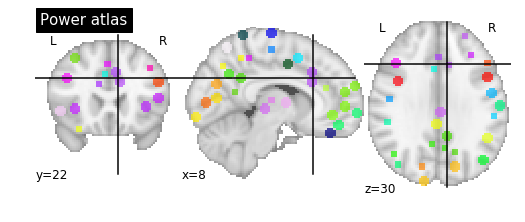

In [11]:
from nilearn import plotting

plotting.plot_roi('/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz', title="Power atlas")

40672
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40672/func/sub-40672_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40672/func/sub-40672_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.transform_single_imgs] Extracting region signals
[NiftiSpheresMasker.transform_single_imgs] Cleaning extracted signals


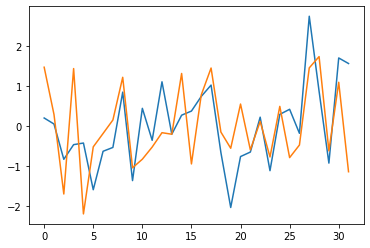

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40672/func/sub-40672_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(32, 266)
execution time: 127.05465006828308
40685
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40685/func/sub-40685_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40685/func/sub-40685_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

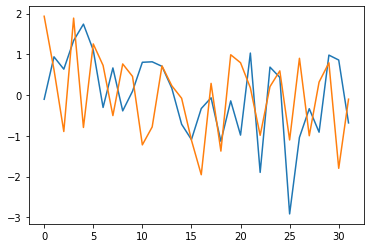

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40685/func/sub-40685_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(32, 266)
execution time: 143.99105191230774
40694
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40694/func/sub-40694_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40694/func/sub-40694_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

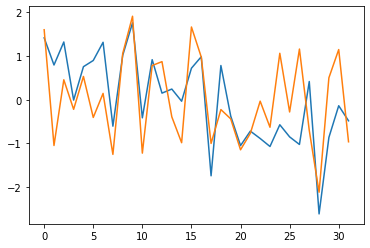

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40694/func/sub-40694_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(32, 266)
execution time: 100.31131601333618
40720
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40720/func/sub-40720_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40720/func/sub-40720_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

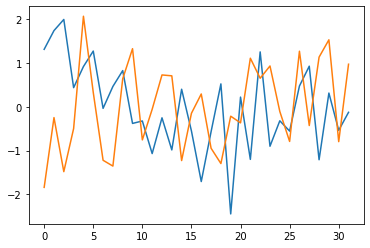

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40720/func/sub-40720_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(32, 266)
execution time: 101.67896389961243
40738
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40738/func/sub-40738_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40738/func/sub-40738_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

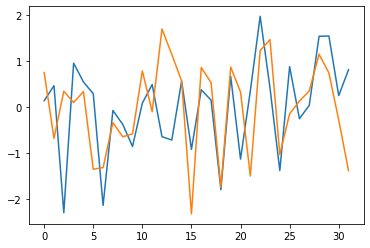

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40738/func/sub-40738_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(32, 266)
execution time: 109.00940990447998
40743
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40743/func/sub-40743_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40743/func/sub-40743_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

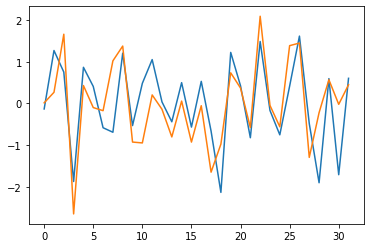

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40743/func/sub-40743_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(32, 266)
execution time: 125.14870023727417
40750
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40750/func/sub-40750_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40750/func/sub-40750_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

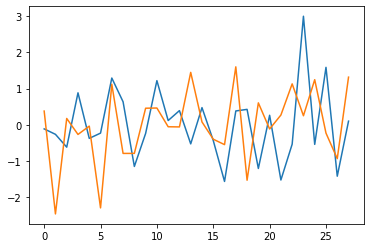

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40750/func/sub-40750_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(28, 266)
execution time: 111.64346599578857
40773
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40773/func/sub-40773_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40773/func/sub-40773_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

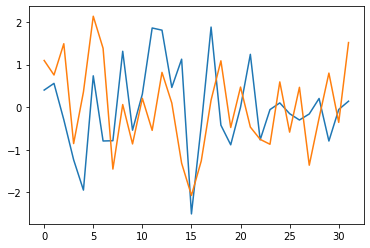

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40773/func/sub-40773_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(32, 266)
execution time: 135.43002796173096
40778
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40778/func/sub-40778_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40778/func/sub-40778_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

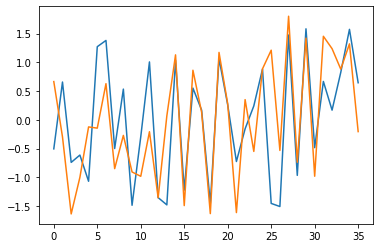

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40778/func/sub-40778_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(36, 266)
execution time: 141.20932793617249
40796
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40796/func/sub-40796_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40796/func/sub-40796_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

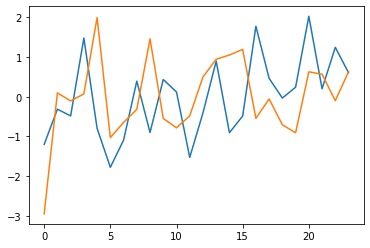

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40796/func/sub-40796_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(24, 266)
execution time: 101.42594408988953
40803
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40803/func/sub-40803_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40803/func/sub-40803_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

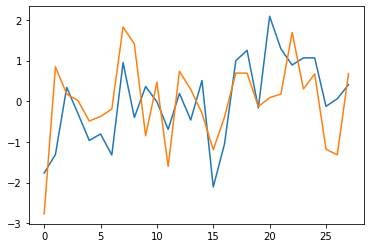

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40803/func/sub-40803_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(28, 266)


/usr/local/lib/python3.9/site-packages/nilearn/connectome/connectivity_matrices.py:333: RuntimeWarning: divide by zero encountered in true_divide
  diagonal = np.atleast_2d(1. / np.sqrt(np.diag(covariance)))
/usr/local/lib/python3.9/site-packages/nilearn/connectome/connectivity_matrices.py:334: RuntimeWarning: invalid value encountered in multiply
  correlation = covariance * diagonal * diagonal.T


execution time: 120.7567400932312
40855
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40855/func/sub-40855_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40855/func/sub-40855_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.transform_single_imgs] Extracting region signals
[NiftiSpheresMasker.transform_single_imgs] Cleaning extracted signals


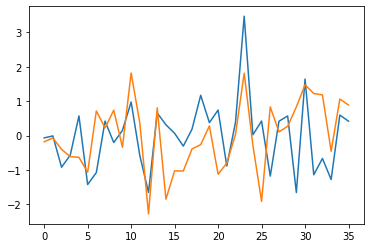

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40855/func/sub-40855_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(36, 266)
execution time: 118.49637484550476
40861
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40861/func/sub-40861_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40861/func/sub-40861_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

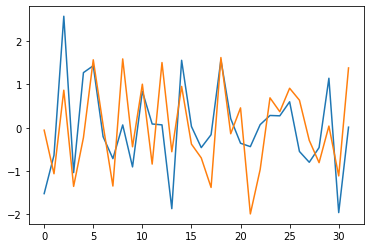

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40861/func/sub-40861_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(32, 266)
execution time: 122.06564903259277
40930
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40930/func/sub-40930_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40930/func/sub-40930_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
File not found: '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40930/fun

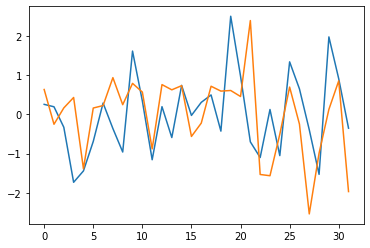

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40961/func/sub-40961_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(32, 266)
execution time: 114.80450820922852
40968
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40968/func/sub-40968_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40968/func/sub-40968_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.tr

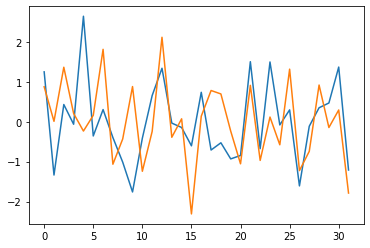

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40968/func/sub-40968_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(32, 266)
execution time: 115.96320700645447


In [8]:
from nilearn.input_data import NiftiLabelsMasker, NiftiSpheresMasker
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import EmpiricalCovariance
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mne.viz import plot_connectivity_circle
import re


def _fisher_r_to_z(x):
    import numpy as np
    # correct any rounding errors
    # correlations cannot be greater than 1.
    x = np.clip(x, -1, 1)

    return np.arctanh(x)

for trial_type in trial_types[:1]:
    
    for subject in subjects[74:]:
        print(subject)
        nibs_dir = '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-' + subject + '/func/'
        out_dir= '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-' + subject + '/func/'

        if not os.path.exists(out_dir.split('/func')[0]):
            os.mkdir(out_dir.split('/func')[0])

        if not os.path.exists(out_dir):
            os.mkdir(out_dir)

        os.chdir(out_dir)

        start_time = time.time()
    
    
        # extract timeseries from every label

        if not os.path.exists(os.path.join(nibs_dir, 'sub-' + subject + '_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-' + trial_type + '_correlation_withhc.tsv')):
            
            try: 
                timeseries_file= nibs_dir + 'sub-' + subject + '_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-' + trial_type + '_betaseries.nii.gz'
                print(timeseries_file)
                
                hc_masker = NiftiSpheresMasker(hc_coords, smoothing_fwhm=6, radius=5.,standardize=True,
                                                       verbose=1)
                
                hc_timeseries = hc_masker.fit_transform(timeseries_file)
                
                plt.plot(hc_timeseries)
                plt.show()
                plt.close()
                
                masker = NiftiLabelsMasker(labels_img=atlas_file,
                                           standardize=True, verbose=1)
                
                timeseries_power = masker.fit_transform(timeseries_file)
                
                timeseries= np.concatenate((timeseries_power, hc_timeseries), axis=1)
                print(timeseries.shape)
                
                # create correlation matrix
                correlation_measure = ConnectivityMeasure(cov_estimator=EmpiricalCovariance(),
                                                          kind="correlation")
                correlation_matrix = correlation_measure.fit_transform([timeseries])[0]
                np.fill_diagonal(correlation_matrix, np.NaN)

                # add the atlas labels to the matrix
                atlas_lut_df = pd.read_csv(atlas_lut, sep='\t')
                regions = atlas_lut_df['regions'].values
                correlation_matrix_df = pd.DataFrame(correlation_matrix, index=regions, columns=regions)

                # do a fisher's r -> z transform
                fisher_z_matrix_df = correlation_matrix_df.apply(_fisher_r_to_z)

                # write out the file.

                corr_mat_fname = 'sub-' + subject + '_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-' + trial_type + '_correlation_withhc.tsv'
                corr_mat_path = os.path.join(out_dir, corr_mat_fname)
                fisher_z_matrix_df.to_csv(corr_mat_path, sep='\t', na_rep='n/a')

                # visualizations with mne
                connmat = fisher_z_matrix_df.values
                labels = list(fisher_z_matrix_df.index)

                # plot a circle visualization of the correlation matrix
                viz_mat_fname = 'sub-' + subject + '_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-' + trial_type + '_correlation_withhc.svg'
                viz_mat_path = os.path.join(out_dir, viz_mat_fname)

                n_lines = int(np.sum(connmat > 0) / 2)
                fig = plt.figure(figsize=(5, 5))

                plot_connectivity_circle(connmat, labels, n_lines=n_lines, fig=fig, title='correlation %s concat' % trial_type,
                                         fontsize_title=10, facecolor='white', textcolor='black',
                                         colormap='jet', colorbar=1, node_colors=['black'],
                                         node_edgecolor=['white'], show=False, interactive=False)

                fig.savefig(viz_mat_path, dpi=300)
                plt.close()
                
                end_time = time.time()
                
                print('execution time: %s' % (end_time - start_time))

            except Exception as e:
                print(e)



[BCT User Guide](https://sites.google.com/site/bctnet/Home/help)

In [77]:
[print(i, sub) for i, sub in enumerate(subjects)]

0 30004
1 30008
2 30009
3 30015
4 30019
5 30020
6 30023
7 30040
8 30057
9 30064
10 30066
11 30069
12 30074
13 30085
14 30088
15 30090
16 30091
17 30095
18 30096
19 30105
20 30116
21 30118
22 30119
23 30128
24 30181
25 30217
26 30227
27 30236
28 30242
29 30255
30 30274
31 30283
32 30295
33 30330
34 30346
35 30376
36 30395
37 30400
38 30403
39 30412
40 30426
41 30432
42 30466
43 30469
44 30476
45 30478
46 30568
47 30570
48 30581
49 30584
50 30588
51 40160
52 40170
53 40175
54 40288
55 40351
56 40490
57 40512
58 40519
59 40520
60 40524
61 40547
62 40564
63 40615
64 40619
65 40624
66 40638
67 40649
68 40650
69 40656
70 40658
71 40664
72 40665
73 40668
74 40672
75 40685
76 40694
77 40720
78 40738
79 40743
80 40750
81 40773
82 40778
83 40796
84 40803
85 40855
86 40861
87 40930
88 40961
89 40968


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [9]:
glob.glob('/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-*/func/sub-*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv')

['/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-40649/func/sub-40649_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv',
 '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-30096/func/sub-30096_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv',
 '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-30432/func/sub-30432_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv',
 '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-40650/func/sub-40650_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv',
 '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-40738/func/sub-40738_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv',
 '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-30074/func/sub-30074_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_de

In [11]:
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc'


In [13]:
x = {}
fc_subs = []

for trial_type in trial_types[:1]:
    print('\n' + trial_type)
    corfiles = glob.glob(nibs_dir + '/sub-*/func/sub-*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-%s_correlation_withhc.tsv' % trial_type)
    corfiles_ya = glob.glob(nibs_dir + '/sub-3*/func/sub-3*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-%s_correlation_withhc.tsv' % trial_type)
    corfiles_oa = glob.glob(nibs_dir + '/sub-4*/func/sub-4*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-%s_correlation_withhc.tsv' % trial_type)
    
    x[trial_type] = np.zeros((266,266, len(corfiles)))
    x[trial_type + '_ya'] = np.zeros((266,266, len(corfiles_ya)))
    x[trial_type + '_oa'] = np.zeros((266,266, len(corfiles_oa)))
    i = 0
    j = 0
    k = 0
    
    for file in sorted(corfiles):
        subject = file.split('sub-')[1][0:5]
        print(subject)
        
        if subject != '30476':
            print(np.vstack(np.array(pd.read_csv(file, sep='\t', na_values="n/a", index_col=0))).shape)
            print('i = %.f' % i)
            x[trial_type][:,:,i] = np.vstack(np.array(pd.read_csv(file, sep='\t', na_values="n/a", index_col=0)))
            np.fill_diagonal(x[trial_type][:,:,i], 0, wrap=False)
            plt.imshow(x[trial_type][:,:,i])
            plt.title(subject)
            plt.show()
            
            fc_subs.append(str(subject))

            if int(subject) < 40000:
                x[trial_type + '_ya'][:,:,j] = np.vstack(np.array(pd.read_csv(file, sep='\t', na_values="n/a", index_col=0)))
                np.fill_diagonal(x[trial_type + '_ya'][:,:,j], 0, wrap=False)
                print('j = %.f \n\n' % j)
                j+=1
            else:
                x[trial_type + '_oa'][:,:,k] = np.vstack(np.array(pd.read_csv(file, sep='\t', na_values="n/a", index_col=0)))    
                np.fill_diagonal(x[trial_type + '_oa'][:,:,k], 0, wrap=False)
                print('k = %.f \n\n' % k)
                k+=1

            i+=1

            
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/fcsubs.txt', fc_subs, fmt='%s')
np.save('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_withhc.npy', x)
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_withhc.mat', x)

# np.savetxt('/Volumes/psybrain/ADM/derivatives/nibs/fcsubs.txt', fc_subs, fmt='%s')
# np.save('/Volumes/psybrain/ADM/derivatives/nibs/withhc/memmatch_fc_withhc.npy', x)
# savemat('/Volumes/psybrain/ADM/derivatives/nibs/withhc/memmatch_fc_withhc.mat', x)


cue
30004
(264, 264)
i = 0


ValueError: could not broadcast input array from shape (264,264) into shape (266,266)

In [382]:
x['cue_ya'].shape

(264, 264, 51)

In [381]:
x['cue_oa'].shape

(264, 264, 37)

In [109]:
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/dsnmat_ya_oa_withhc.mat', {'dsn_ya_oa': np.hstack((np.vstack((np.ones((51,1)), np.zeros((37,1)))), np.vstack((np.zeros((51,1)), np.ones((37,1))))))})

Remove 30476

In [93]:
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/memmatch_fc_dmn-fpn-hc.mat', {'fc_dmnfpn': x['cue'][dmn_fpn][:,dmn_fpn]})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/memmatch_fc_dmn-hc.mat', {'fc_dmn': x['cue'][dmn][:,dmn]})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/memmatch_fc_fpn-hc_.mat', {'fc_fpn_hc': x['cue'][fpn_hc][:,fpn_hc]})

In [94]:
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/coords_fpn-hc.txt', coords[fpn_hc], fmt = '%s')
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/coords_dmn-hc.txt', coords[dmn], fmt = '%s')
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/coords_dmn-fpn-hc.txt', coords[dmn_fpn], fmt = '%s')

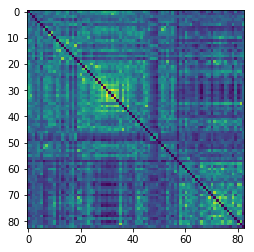

In [62]:
plt.imshow(x['cue'][dmn_fpn][:,dmn_fpn].mean(axis=2))

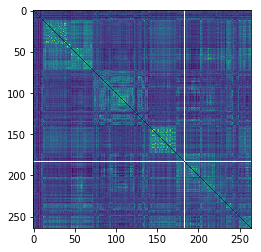

In [63]:
plt.imshow(x['cue_ya'].mean(axis=2))

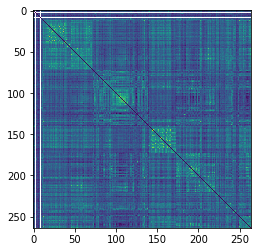

In [64]:
plt.imshow(x['cue_oa'].mean(axis=2))

In [10]:
atlas.loc[fpn].values.flatten()

array(['Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control', 'Fronto-parietal Task Control',
       'Fronto-parietal Task Control'], dtype=object)

In [774]:
pd.DataFrame(np.hstack((coords[dmn_fpn], atlas.loc[dmn_fpn].values))).values.tolist()

[[6, 67, -4, 'Default mode'],
 [8, 48, -15, 'Default mode'],
 [-13, -40, 1, 'Default mode'],
 [-18, 63, -9, 'Default mode'],
 [-46, -61, 21, 'Default mode'],
 [43, -72, 28, 'Default mode'],
 [-44, 12, -34, 'Default mode'],
 [46, 16, -30, 'Default mode'],
 [-68, -23, -16, 'Default mode'],
 [-58, -26, -15, 'Default mode'],
 [-39, -75, 44, 'Default mode'],
 [-7, -55, 27, 'Default mode'],
 [6, -59, 35, 'Default mode'],
 [-11, -56, 16, 'Default mode'],
 [-3, -49, 13, 'Default mode'],
 [8, -48, 31, 'Default mode'],
 [15, -63, 26, 'Default mode'],
 [-2, -37, 44, 'Default mode'],
 [11, -54, 17, 'Default mode'],
 [52, -59, 36, 'Default mode'],
 [23, 33, 48, 'Default mode'],
 [-10, 39, 52, 'Default mode'],
 [-16, 29, 53, 'Default mode'],
 [-35, 20, 51, 'Default mode'],
 [22, 39, 39, 'Default mode'],
 [13, 55, 38, 'Default mode'],
 [-10, 55, 39, 'Default mode'],
 [-20, 45, 39, 'Default mode'],
 [6, 54, 16, 'Default mode'],
 [6, 64, 22, 'Default mode'],
 [-7, 51, -1, 'Default mode'],
 [9, 54, 3, '

## Age group differences in DMN-FPN FC during cue <a id='age-group-dif-mean-fc'></a>

In [18]:
x = np.load('/Volumes/psybrain/ADM/derivatives/nibs/memmatch_fc.npy', allow_pickle=True).flat[0]
fc_subs = np.loadtxt('/Volumes/psybrain/ADM/derivatives/nibs/fcsubs.txt')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


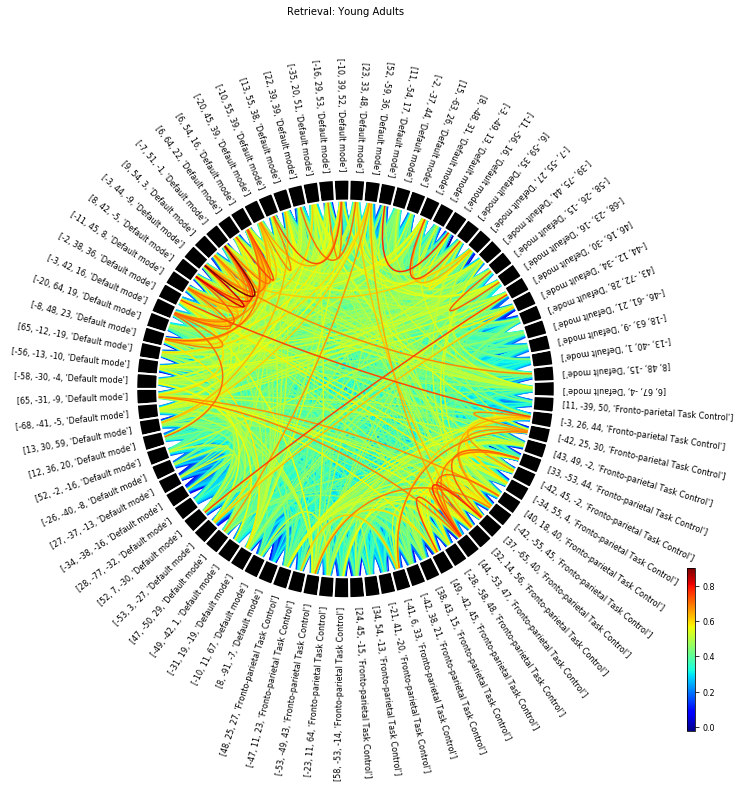

In [468]:
xpy = x['cue_ya'].mean(axis=2)

n_lines = int(np.sum((xpy > 0) / 2))
fig = plt.figure(figsize=(15, 15))
node_labels = pd.DataFrame(np.hstack((coords[dmn_fpn], atlas.loc[dmn_fpn].values))).values.tolist()             
plot_connectivity_circle(xpy[dmn_fpn][:,dmn_fpn], node_labels, n_lines=n_lines, fig=fig, title='Retrieval: Young Adults', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)
fig.savefig(results_dir + 'cue_ya_mean_dmn-fpn_fc.png')

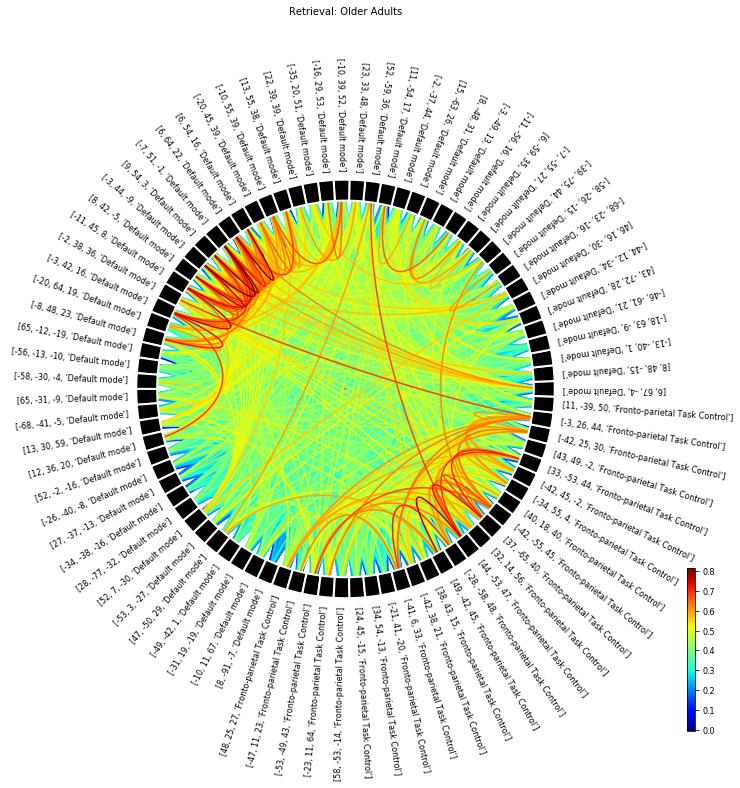

In [469]:
xpo = x['cue_oa'].mean(axis=2)
fig = plt.figure(figsize=(15, 15))

node_labels = pd.DataFrame(np.hstack((coords[dmn_fpn], atlas.loc[dmn_fpn].values))).values.tolist()
plot_connectivity_circle(xpo[dmn_fpn][:,dmn_fpn], node_labels, n_lines=n_lines, fig=fig, title='Retrieval: Older Adults', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)

fig.savefig(results_dir + 'cue_oa_mean_dmn-fpn_fc.png')


In [39]:
x['cue_ya'].shape

(264, 264, 51)

In [40]:
x['cue_oa'].shape

(264, 264, 37)

In [43]:
x['cue_oa'][:,:,35]

array([[0.        , 0.63977629, 0.01653341, ..., 0.34015785, 0.03554068,
        0.21508494],
       [0.63977629, 0.        , 0.30250593, ..., 0.67654755, 0.31423401,
        0.39361927],
       [0.01653341, 0.30250593, 0.        , ..., 0.35144185, 0.09509778,
        0.32740648],
       ...,
       [0.34015785, 0.67654755, 0.35144185, ..., 0.        , 0.53777688,
        0.36343411],
       [0.03554068, 0.31423401, 0.09509778, ..., 0.53777688, 0.        ,
        0.19420943],
       [0.21508494, 0.39361927, 0.32740648, ..., 0.36343411, 0.19420943,
        0.        ]])

In [44]:
x['cue_ya'][fpn][:,fpn,:].shape

(25, 25, 51)